## Модель Inception

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [ ]:
# Встановлюємо фіксоване зерно для відтворюваності результатів
tf.random.set_seed(42)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


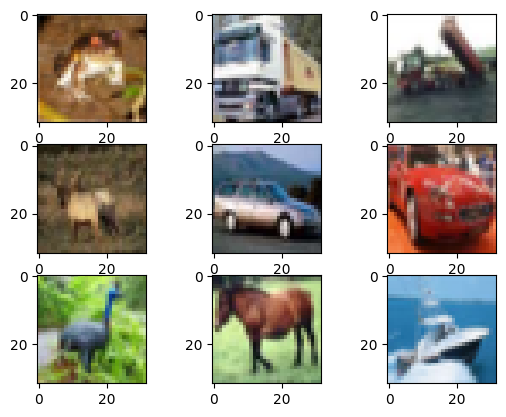

In [ ]:
# Завантаження даних CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # Завантажуємо дані CIFAR-10, розподіляючи їх на навчальний та тестовий набори
img_rows, img_cols , channels= 32,32,3 # Задаємо розміри зображень (32x32) та кількість каналів (3, оскільки зображення кольорові)

# Виводимо перші 9 зображень з навчального набору даних
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [ ]:
# Аугментація даних
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

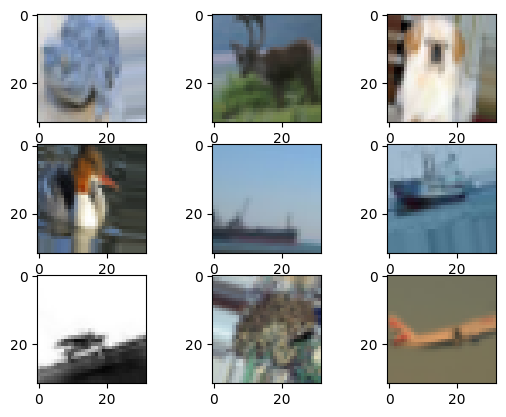

In [ ]:
# Перевірка аугментованих зображень
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [ ]:
# Змінюємо форму масиву, щоб він відповідав очікуваній формі на вході в мережу
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
# Змінюємо тип даних зображень на float32
x_train=x_train.astype("float32")
x_test=x_test.astype("float32")

# Обчислююємо середнє та стандартне відхилення для нормалізації
mean=np.mean(x_train)
std=np.std(x_train)

# Нормалізуюємо дані, для покращення продуктивністі моделі
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [ ]:
num_classes=10 # Визначаємо кількість класів у наборі даних (CIFAR-10 містить 10 класів)

# Перетворюємо цільові мітки у формат one-hot encoding (стандартно для роботи з категоріальними даними у нейронних мережах)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
# Функція для створення Inception блоку
def inception_module(x, filters):
    # Гілка з 1x1 згорткою
    conv1x1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)

    # Гілка з 3x3 згорткою
    conv3x3 = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)

    # Гілка з 5x5 згорткою
    conv5x5 = Conv2D(filters, (5, 5), padding='same', activation='relu')(x)

    # Гілка з MaxPooling та 1x1 згорткою
    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    maxpool_conv = Conv2D(filters, (1, 1), padding='same', activation='relu')(maxpool)

    # Об'єднуємо всі гілки
    output = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, maxpool_conv])
    return output

In [ ]:
# Побудова моделі

input_layer = Input(shape=(img_rows, img_cols, channels)) # Визначаємо вхідний шар з розміром зображень

# Початковий згортковий шар
x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer) # Застосовуємо 64 згорткові фільтри розміром 3x3
x = BatchNormalization()(x) # Нормалізуємо активації між шарами для прискорення навчання

# Inception блоки
x = inception_module(x, 32) # Додаємо Inception модулі з різними кількостями фільтрів
x = inception_module(x, 64)
x = MaxPooling2D(pool_size=(2, 2))(x) # Зменшуємо розмір зображення на половину

x = inception_module(x, 128)
x = inception_module(x, 128)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Плоский шар і щільні шари
x = Flatten()(x) # Перетворюємо 2D-вихід на одномірний масив
x = Dense(512, activation='relu')(x) # Додаємо повнозв'язний шар з 512 нейронами
x = BatchNormalization()(x)
x = Dropout(0.4)(x) # Вимикаємо 40% нейронів для запобігання перенавчанню
output_layer = Dense(num_classes, activation='softmax')(x) # Вихідний шар з softmax (перетворює значення на ймовірності для кожного класу)

In [ ]:
# Створення та компіляція моделі
model = Model(inputs=input_layer, outputs=output_layer)
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Перевірка структури моделі
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │          2,080 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 32)     │         18,464 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 32)     │         51,232 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │          2,080 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 128)    │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ concatenate[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │          8,256 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 64)     │         73,792 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 64)     │        204,864 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 64)     │          8,256 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0],        │
│ (Concatenate)             │                        │                │ conv2d_6[0][0],        │
│                           │                        │                │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_8[0][0]         │
├──────────────────────

 Total params: 20,695,946 (78.95 MB)

 Trainable params: 20,694,794 (78.94 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
# Зворотні виклики
checkpoint = ModelCheckpoint("inception_cifar10_best.keras", save_best_only=True) # Зберігаємо модель з найкращими показниками на валідації
early_stopping = EarlyStopping(patience=10, restore_best_weights=True) # Зупиняємо навчання, якщо показники не покращуються протягом 10 епох
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001) # Зменшуємо швидкість навчання, якщо валідаційна втрата не покращується.

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    steps_per_epoch=None,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 115s 121ms/step - accuracy: 0.3665 - loss: 1.8650 - val_accuracy: 0.5335 - val_loss: 1.3360 - learning_rate: 1.0000e-04
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 120s 112ms/step - accuracy: 0.5340 - loss: 1.3418 - val_accuracy: 0.6391 - val_loss: 1.0370 - learning_rate: 1.0000e-04
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 101ms/step - accuracy: 0.5974 - loss: 1.1569 - val_accuracy: 0.6388 - val_loss: 1.1056 - learning_rate: 1.0000e-04
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 102ms/step - accuracy: 0.6432 - loss: 1.0268 - val_accuracy: 0.6761 - val_loss: 1.0399 - learning_rate: 1.0000e-04
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 85s 106ms/step - accuracy: 0.6663 - loss: 0.9486 - val_accuracy: 0.6867 - val_loss: 0.9368 - learning_rate: 1.0000e-04
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 86s 109ms/step - accuracy: 0.6953 - loss: 0.8831 - val_accuracy: 0.7288 - val_loss: 0.8587 - learning_rate: 1.0000e-04
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 109m

In [ ]:
# Оцінка моделі
model_test_acc = model.evaluate(x_test, y_test, batch_size=64)
model_train_acc = model.evaluate(x_train, y_train, batch_size=64)

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8878 - loss: 0.3545
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9458 - loss: 0.1622


In [ ]:
print(f"Тренувальний accuracy: {model_train_acc[1] * 100:.2f}%")
print(f"Тренувальний loss: {model_train_acc[0] * 100:.2f}%")
print(f"Тестовий accuracy: {model_test_acc[1] * 100:.2f}%")
print(f"Тестовий loss: {model_test_acc[0] * 100:.2f}%")

Тренувальний accuracy: 94.46%
Тренувальний loss: 16.49%
Тестовий accuracy: 88.38%
Тестовий loss: 36.16%


In [ ]:
# функція для побудови графіка точності навчання та валідації по епохах
def plothist(hist):
    plt.rcParams["figure.figsize"] = (13, 4)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

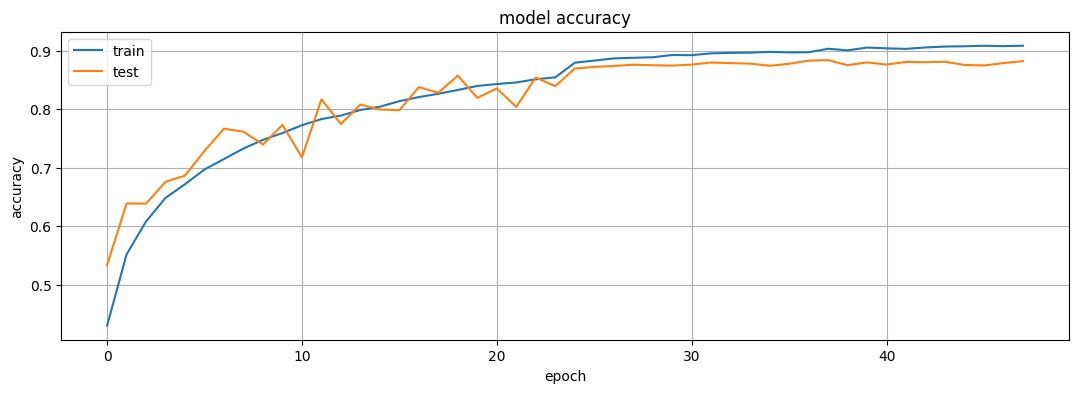

In [ ]:
plothist(history)

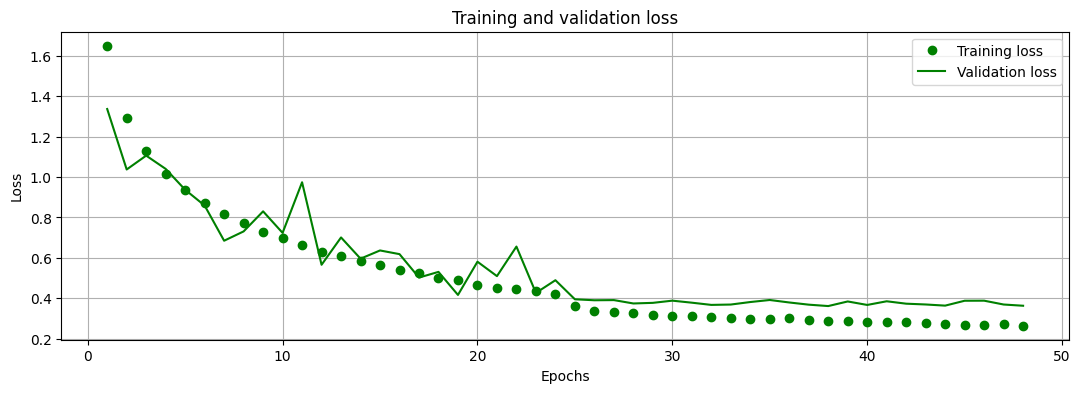

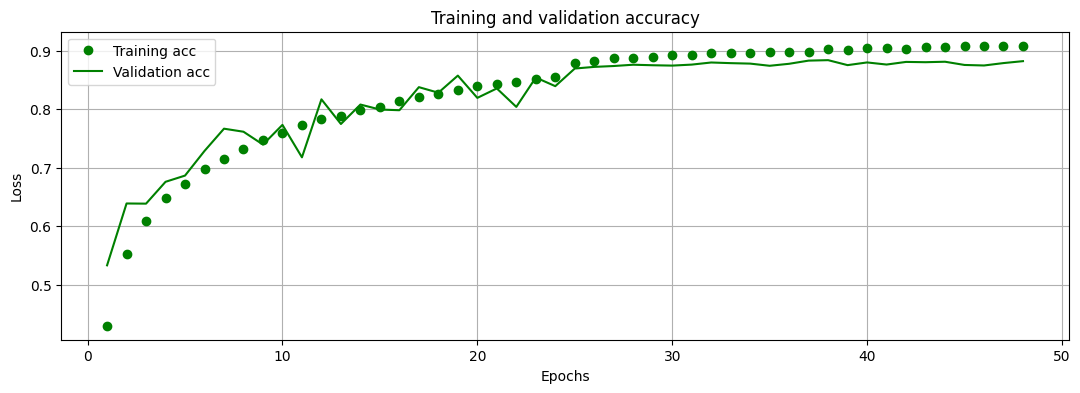

In [ ]:
# Побудова графіків втрат та точності

history_dict = history.history # Зберігаємо історію навчання

# Зберігаємо втрати на тренуванні та валідації
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.rcParams["figure.figsize"] = (13, 4)
plt.plot(epochs, loss_values, 'go', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs, history_dict['accuracy'], 'go', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Збереження моделі, завантаження моделі і перевірка на зображеннях

In [ ]:
model.save("cifar10_inception_result_update.keras")

In [ ]:
# model.save_weights("cifar10_inception_result_update.weights.h5")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Переміщення файлу на Google Drive
!cp /content/cifar10_inception_result_update.keras "/content/drive/MyDrive/NeuroContact/"

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Завантаження моделі
model_path = '/content/drive/MyDrive/NeuroContact/cifar10_inception_result_update.keras'
model = tf.keras.models.load_model(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: airplane


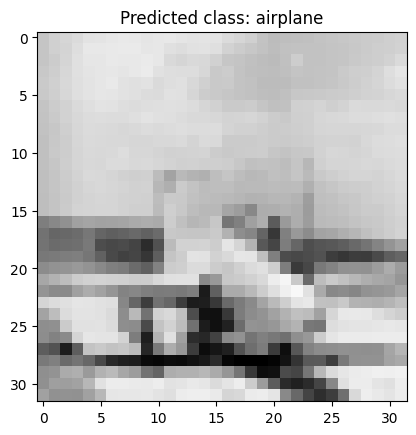

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted class: automobile


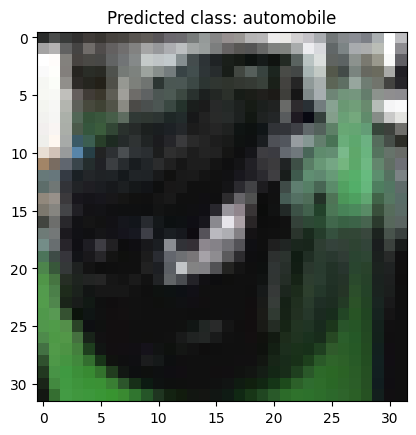

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted class: deer


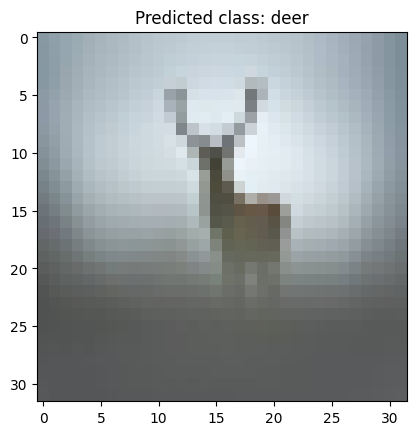

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted class: dog


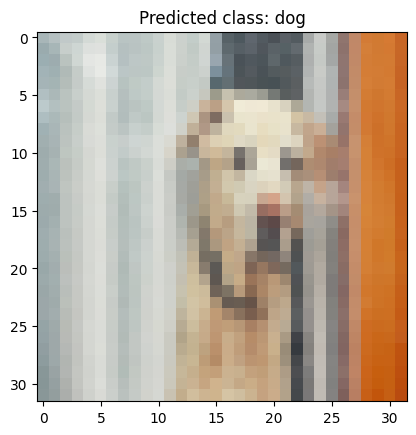

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted class: airplane


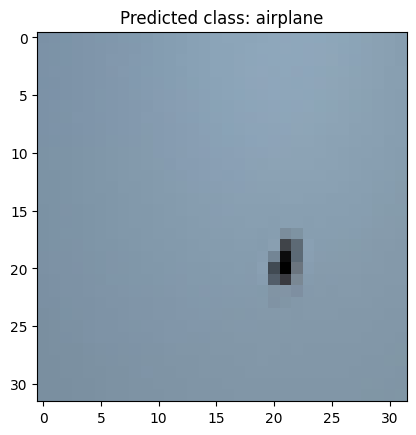

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted class: truck


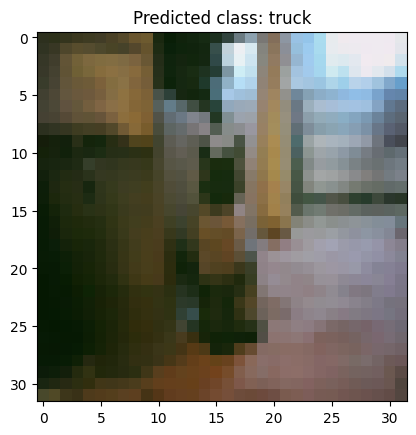

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted class: horse


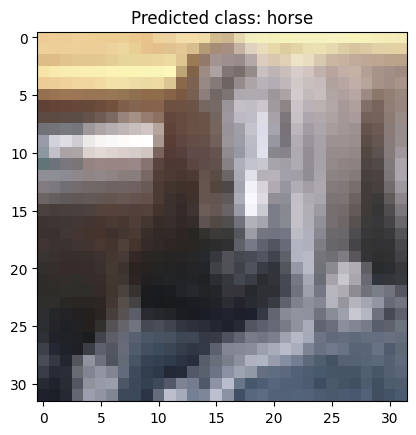

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted class: frog


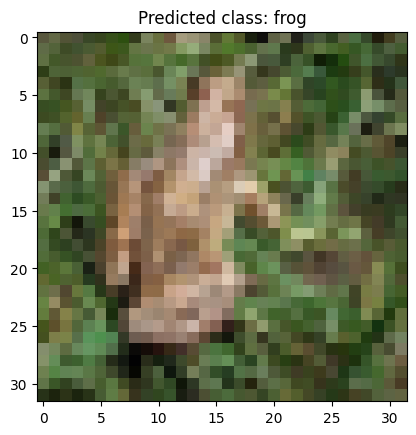

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted class: horse


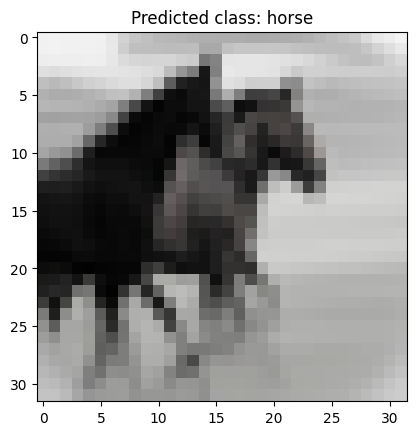

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted class: frog


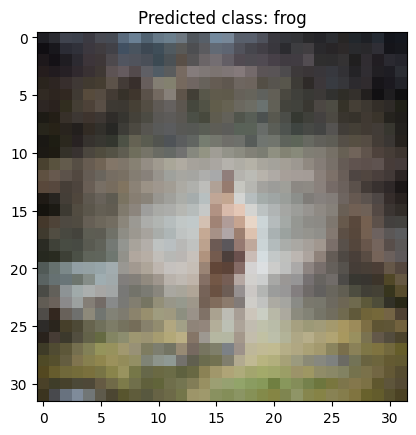

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted class: truck


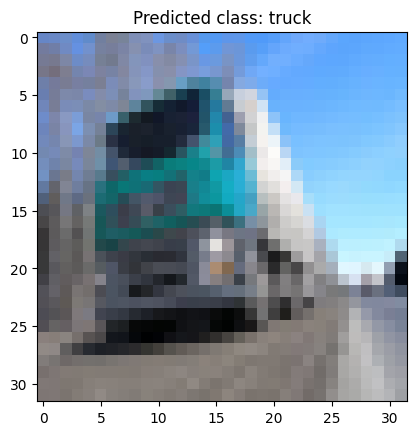

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted class: frog


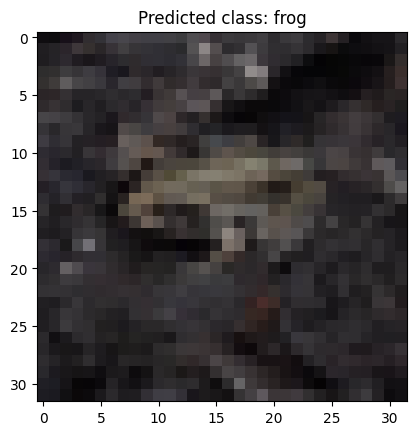

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Predicted class: airplane


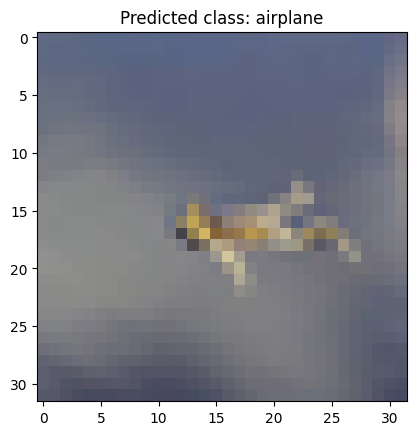

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Predicted class: horse


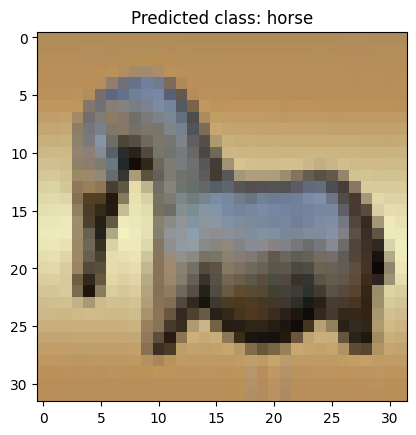

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predicted class: ship


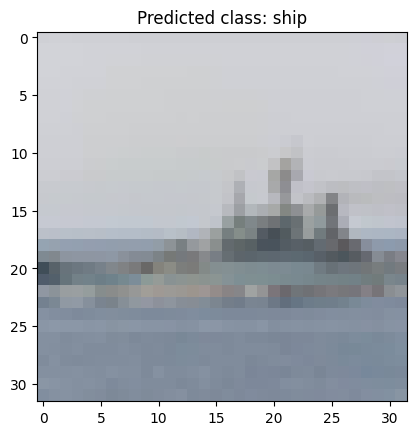

In [5]:
# Завантаження зображення з локального файлу
# Вказати шлях до файлу на Google Диску

import os


my_list = [i for i in os.listdir('/content/drive/MyDrive/NeuroContact/predict_images_bad_quality') if i.lower().endswith(('.jpg'))]


# Завантаження зображення

def predict_image(file):

  img = Image.open(file)

  # Підготовка зображення
  img = img.resize((32, 32))  # зміна розміру зображення до розмірів CIFAR-10
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = img_array.astype('float32') / 255.0  # нормалізація зображення

  # Передбачення
  predictions = model.predict(img_array)
  predicted_class = np.argmax(predictions[0])

  # Класи CIFAR-10
  class_names = [
      'airplane', 'automobile', 'bird', 'cat', 'deer',
      'dog', 'frog', 'horse', 'ship', 'truck'
  ]

  # Виведення результату
  print(f"Predicted class: {class_names[predicted_class]}")
  plt.imshow(img)
  plt.title(f"Predicted class: {class_names[predicted_class]}")
  plt.show()


for i in my_list:
  predict_image(f'/content/drive/MyDrive/NeuroContact/predict_images_bad_quality/{i}')